# Training the model on synthetically modified data

## Introduction

To investigate different potential scenarios of systematic differences in measurement instruments and their effect on how well they can be aligned to a common trajectory in a latent space, we create modifications of the dataset and artificially introduce different sources of discrepancies. 
Specifically, we use data from one measurement instrument only and use a subscale, i.e., a subset of items, as the synthetic second measurement instrument.

We use the RULM assessment from the SMArtCARE registry as the original measurement instrument. Thus, from the full SMA dataset described in Section 3.1 in the manuscript, we consider only the patients with RULM measurements. We use a subscale of the RULM items, comprising $5$ items that concern the handling of small weights as second measurement instrument. 
When the complete subscale also remains part of the larger instrument, i.e., the information in our second measurement instrument is fully contained in the first measurement instrument.
When no modifications are introduced, a close alignment should thus be feasible in principle. The following notebook, we present this baseline scenario and visualize the alignment of the two measurement instruments in the latent space over the course of several training epochs.


## Setup

We start by loading the Julia environment, the necessary package libraries and functions from the `src` directory that we will use in this notebook.

### Julia environment

In [43]:
cd(@__DIR__)

using Pkg;
Pkg.activate("../.")
Pkg.status()

Status `~/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/Project.toml`
⌃ [6e4b80f9] BenchmarkTools v1.3.2
⌃ [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [b4f34e82] Distances v0.10.10
⌃ [31c24e10] Distributions v0.25.102
⌅ [587475ba] Flux v0.13.17
  [38e38edf] GLM v1.9.0
⌃ [b964fa9f] LaTeXStrings v1.3.0
  [442fdcdd] Measures v0.3.2
  [6f286f6a] MultivariateStats v0.10.2
⌃ [429524aa] Optim v1.7.8
  [d96e819e] Parameters v0.12.3
⌃ [91a5bcdd] Plots v1.39.0
⌃ [92933f4c] ProgressMeter v1.9.0
⌃ [2913bbd2] StatsBase v0.34.2
  [3eaba693] StatsModels v0.7.3
⌃ [f3b207a7] StatsPlots v0.15.6
⌃ [112f6efa] VegaLite v3.2.3
⌃ [e88e6eb3] Zygote v0.6.59
  [9a3f8284] Random
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


  Activating project at `~/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean`


### Package libraries

In [44]:
using CSV
using Dates
using DataFrames
using Distributions
using Random
using GLM
using Flux
using LaTeXStrings
using LinearAlgebra
using Measures
using Plots
using Parameters
using ProgressMeter
using StatsBase

### Loading functions

In [45]:
sourcedir = "../src/"
include(joinpath(sourcedir, "load_data.jl"))
include(joinpath(sourcedir, "model.jl"))
include(joinpath(sourcedir, "ODE_solutions.jl"))
include(joinpath(sourcedir, "training.jl"))
include(joinpath(sourcedir, "training_modifications.jl"))
include(joinpath(sourcedir, "eval_modifications.jl"))
include(joinpath(sourcedir, "plot_latent.jl"))

plot_selected_ids_final (generic function with 1 method)

## Loading and preparing data 

We load the baseline information and the timedependent data separately. We subset to the RULM measurements only, then prepare the data for the training process. Specifically, we re-format the data into custom data structures and recode the items (for details, see the corresponding functions or the manuscript).

In [46]:
data_path = joinpath("../dataset/")

baseline_df = CSV.File(string(data_path, "baseline_df.csv"), truestrings = ["TRUE", "M"], falsestrings = ["FALSE", "F"], missingstring = ["NA"], decimal=',') |> DataFrame
timedepend_df = CSV.File(string(data_path, "timedepend_df.csv"), truestrings = ["TRUE"], falsestrings = ["FALSE"], missingstring = ["NA"], decimal=',') |> DataFrame

# remove "Column1"
baseline_df = baseline_df[:,2:end]
timedepend_df = timedepend_df[:,2:end]

# preprocess data for a specific test 
test = "rulm"
testdata, sumscores, keep_timepoint_masks = get_SMArtCARE_data(test, baseline_df, timedepend_df, extended_output=true);
# recode items 
recoded_testdata = recode_SMArtCARE_data(testdata);

┌ Warning: there were duplicate rows for patient id 86535, skipping these...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/load_data.jl:329


We then define and prepare the synthetic second measurement instrument as a subscale of the first: we select the items that concern the handling of small weights from the RULM assessment and create a new dataset with these items only.

In [47]:
subscale2_letters = ["j", "k", "l", "m", "n"]
subscale2_names = collect("rulm_item$(letter)" for letter in subscale2_letters)
subscale2_inds = [10, 11, 12, 13, 14]
testdata2 = get_SMArtCARE_data(test, baseline_df, timedepend_df, var_names=subscale2_names);
#xs2, xs_baseline2, tvals2, ids2 = testdata2.xs, testdata2.xs_baseline, testdata2.tvals, testdata2.ids;
recoded_testdata2 = recode_SMArtCARE_data(testdata2);

┌ Warning: there were duplicate rows for patient id 86535, skipping these...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/load_data.jl:329


We now use the two preprocessed measurement instrument datasets to create a joint dataset, stored again in a custom data structure, `SMAMixedTestData`.

In [48]:
mixeddata = SMAMixedTestData("rulm_handle_weights", "rulm", 
                            recoded_testdata2.xs, recoded_testdata.xs, 
                            recoded_testdata.xs_baseline,
                            recoded_testdata2.tvals, recoded_testdata.tvals, 
                            recoded_testdata2.ids, recoded_testdata2.ids, recoded_testdata2.ids
);

Finally, we set up the directory structure for saving the reults:

In [49]:
#setup directory structure for saving results 
parentdir = "../results"
!isdir(parentdir) && mkdir(parentdir)

pathname = joinpath(parentdir, "no_modification")
resultspath = pathname
!isdir(resultspath) && mkdir(resultspath)

false

## Define model and training hyperparameters

We set up and configure a system for training a model by defining the ODE dynamics, loss functions, and training parameters. The dynamic system is set to a full homogeneous ODE system. 

We then set parameters for the loss function, specifically the `penaltytype`, the `penaltyweight` and the `penaltyoffset` (see the Methods Section of the manuscript for more explanation on the loss function and its terms). 
These parameters are used to create a `LossArgs` object containing the parameters that control the loss function. 

We then define training hyperparameters: the learning rate `lr`, and `epoch_checkpoints`, a list of epochs at which the model will be evaluated.

In [50]:
# set dynamics to full homogeneous ODE system
dynamics = params_fullhomogeneous 

# define numbers of individuals and variables 
n = length(recoded_testdata.xs)

# define loss function details
penaltytype = :sum_ratio
penaltyweight = 5.0f0
penaltyoffset = 1.0f0

# loss args
args_joint=LossArgs(
    λ_adversarialpenalty=5.0f0,
    skipt0=true, 
    weighting=true, 
    λ_variancepenalty = penaltyweight,
    variancepenaltytype = penaltytype,
    variancepenaltyoffset = penaltyoffset, 
    λ_μpenalty=5.0f0
)

# training hyperparameters: learning rate and epochs
lr = 0.001
epoch_checkpoints = [2, 5, 10, 12, 15, 18, 20, 25, 30]

9-element Vector{Int64}:
  2
  5
 10
 12
 15
 18
 20
 25
 30

Then, we set up the model by defining two model configurations, `modelargs1` and `modelargs2`, for the respective VAE of each measurement instrument. Specifically, `p` corresponds to the number of time-depedenent variables and `q` to the number of baseline variables. The `dynamics` are set to the previously defined ODE dynamics. 
Both models have a `seed` value for reproducibility. 
The last settings concern the setup of the additional neural network that maps the baseline variables to a set of individual-specific ODE parameters (see the implementation details in the Appendix of the manuscript or the definition of the `odevae` struct in `model.jl` for details).

We initialize both models, `m1` and `m2`, using the `odevae` function with the respective model configurations.

In [51]:
# define model 
modelargs1 = ModelArgs(p=size(mixeddata.xs1[1],1), 
                    q=length(mixeddata.xs_baseline[1]), # zdim=2 default
                    dynamics=dynamics,
                    seed=1234, #1234
                    bottleneck=false, #true, #false for 2 param systems
                    scale_sigmoid=2.0f0, # Struktur des ODE-net: zulässiger Bereich der ODE-Parameter
                    add_diagonal=true # Struktur des ODE-net: Diagonal-Layer am Ende Ja/Nein
)

modelargs2 = ModelArgs(p=size(mixeddata.xs2[1],1), 
                    q=length(mixeddata.xs_baseline[1]), # zdim=2 default
                    #nODEparams=nODEparams,
                    dynamics=dynamics,
                    bottleneck=false,
                    seed=1234,
                    scale_sigmoid=2, # Struktur des ODE-net: zulässiger Bereich der ODE-Parameter
                    add_diagonal=true # Struktur des ODE-net: Diagonal-Layer am Ende Ja/Nein
)

m1 = odevae(modelargs1);
m2 = odevae(modelargs2);

## Training the model

First, we illustrate what happens at an epoch checkpoint. We then train the model for a number of epochs in a loop, evaluating and saving the results at each checkpoint.

First, we train the model for the specified number of epochs. By setting `verbose=true`, we can print out the loss function value after each training epoch.

In [52]:
epoch_name = 3 # this is absolute number of epochs the model is trained for
train_epochs = 3 # this corresponds to the number of epochs to train the model after the previous checkpoint

trainingargs_joint=TrainingArgs(warmup=false, epochs=train_epochs, lr=lr)
train_mixed_model!(m1, m2, mixeddata, args_joint, trainingargs_joint, 
    verbose=true, plotting=false
)

┌ Info: initializing training...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:43
┌ Info: starting training for 3 epochs
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:81
┌ Info: 1
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:84


mean((loss(data..., m1, m2, args = lossargs) for data = trainingdata_joint)) = 631.5057f0


┌ Info: 2
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:84


mean((loss(data..., m1, m2, args = lossargs) for data = trainingdata_joint)) = 316.64627f0


┌ Info: 3
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:84


mean((loss(data..., m1, m2, args = lossargs) for data = trainingdata_joint)) = 265.0526f0


For evaluating the model, we calculate the mean absolute difference between the latent representations of each measurement instrument at all time points where both measurement instruments were observed: 

\begin{equation*}
    \Delta_i^{R,S} := \frac{1}{|t_i^R \cap t_i^S|} \sum_{t \in t_i^R \cap t_i^S} \mid \mu_i^{R, t} - \mu_i^{S,t} \mid \in \R^d.
\end{equation*}

To compare the values of $\Delta_i^{R,S}$ across patients, we thus consider them in relation to the variability of each patient's ODE trajectory and calculate for each patient the absolute difference between the values of the ODE solution at the first and last time point of the time interval:

\begin{equation*}
    \Delta_i^{\mathrm{ODE}} := \mid \widetilde{\mu}_i(t_{\max\lbrace T_i^R, T_i^S \rbrace}), \eta_i) - \widetilde{\mu}_i(t_0, \eta_i) \mid \in \R^d.
\end{equation*}

For each scenario, we calculate $\Delta_i^{R,S}$ and $\Delta_i^{\mathrm{ODE}}$ for all patients $i=1, \dots, N$ and visualize them in scatterplots.

First, we calculate the $\Delta_i^{R,S}$ and $\Delta_i^{\mathrm{ODE}}$ values and save them in a dataframe: 

In [53]:
agg_abs_delta_df = make_df_from_deltas(m1, m2, mixeddata)

798×6 DataFrame
 Row │ patient_id  latent_dimension  mean_abs_delta  ode_delta   abs_ode_delta ⋯
     │ Int64       Int64             Float32         Real?       Real?         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        222                 1        1.07945   -1.29043        1.29043   ⋯
   2 │        222                 2        2.20024    1.76845        1.76845
   3 │        392                 1        0.420325  -0.502066       0.502066
   4 │        392                 2        3.10303    0.845809       0.845809
   5 │        678                 1        0.40163   -0.12306        0.12306   ⋯
   6 │        678                 2        1.64382   -0.0865595      0.0865595
   7 │        856                 1        2.656     -0.186291       0.186291
   8 │        856                 2        1.02542    0.0387196      0.0387196
  ⋮  │     ⋮              ⋮                ⋮             ⋮             ⋮       ⋱
 792 │      99330                 2        2.19622    0.340229       0.340229  ⋯
 793 │      99609                 1        2.51102   -0.929371       0.929371
 794 │      99609                 2        0.979959   3.50584        3.50584
 795 │      99871                 1        0.508195  -0.731575       0.731575
 796 │      99871                 2        2.07146    1.25526        1.25526   ⋯
 797 │      99944                 1        0.296892  -0.407699       0.407699
 798 │      99944                 2        2.7962    -0.0913929      0.0913929
                                                   1 column and 783 rows omitted

Then, we create a scatterplot to visualize them: 

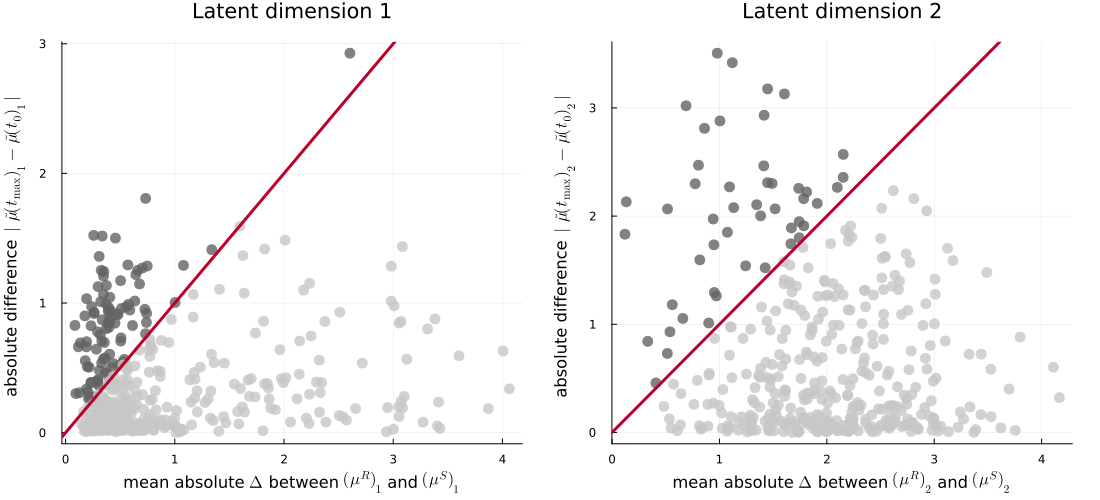

In [54]:
deltaplot = create_delta_scatterplots(agg_abs_delta_df, 
    fix_limits=false,
    saveplot=true, 
    savepath=resultspath,
    filename="delta_scatterplot_$(epoch_name)epochs.pdf"
)
deltaplot

Additionally, we calculate the percentage of points above the diagonal, separate for each dimension and in total, and save this dataframe to a CSV file:  

In [55]:
above_diagonal_df = collect_stats_about_deltas(agg_abs_delta_df)
CSV.write(joinpath(resultspath, "above_diagonal_stats_$(epoch_name)epochs.csv"), above_diagonal_df)
above_diagonal_df

3×4 DataFrame
 Row │ dimension  no_above_diagonal  no_total  perc_above_diagonal 
     │ Any        Int64              Int64     Float64             
─────┼─────────────────────────────────────────────────────────────
   1 │ 1                         96       399             0.240602
   2 │ 2                         48       399             0.120301
   3 │ overall                  144       798             0.180451

Now, we run the steps detailed above in a loop over the specified number of epochs, saving the results at each checkpoint. These results correspond to the scatterplots shown in Figure 2 in the manuscript and the corresponding percentages reported in Table 4. 

┌ Info: Trainig model until epoch 2...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/notebooks/SyntheticallyModifiedDataScenario.ipynb:16
┌ Info: initializing training...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:43
┌ Info: starting training for 2 epochs
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:81
┌ Info: 1
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:84
┌ Info: 2
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/src/training.jl:84
┌ Info: Trainig model until epoch 5...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasurementInstruments/clean/notebooks/SyntheticallyModifiedDataScenario.ipynb:16
┌ Info: initializing training...
└ @ Main /Users/imbi-mac-102/Desktop/smartcare/ODE-VAE/MappingMeasure

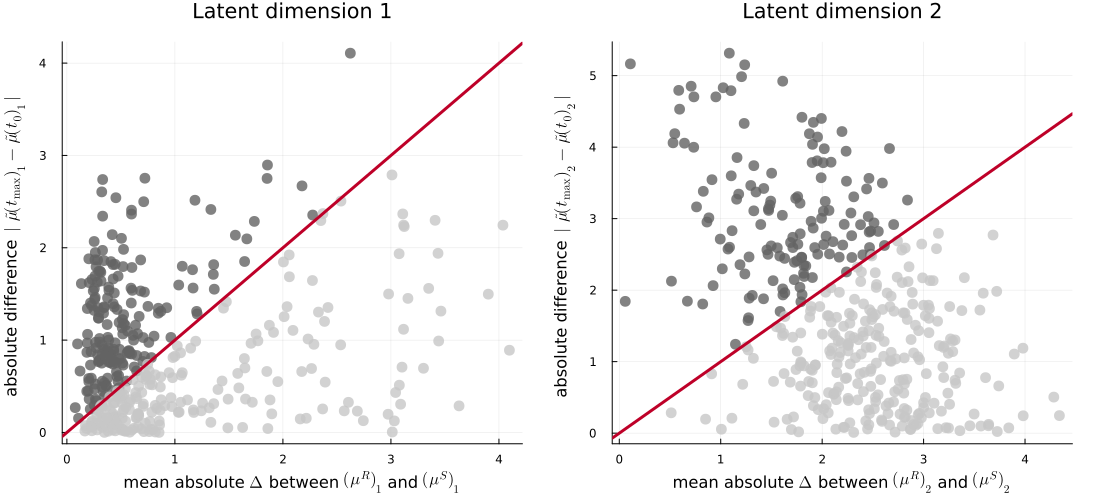

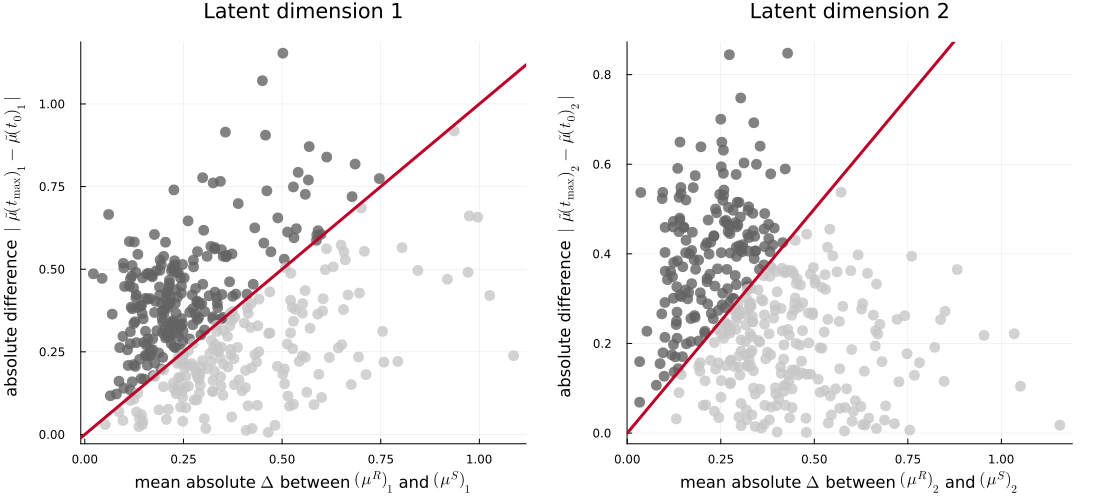

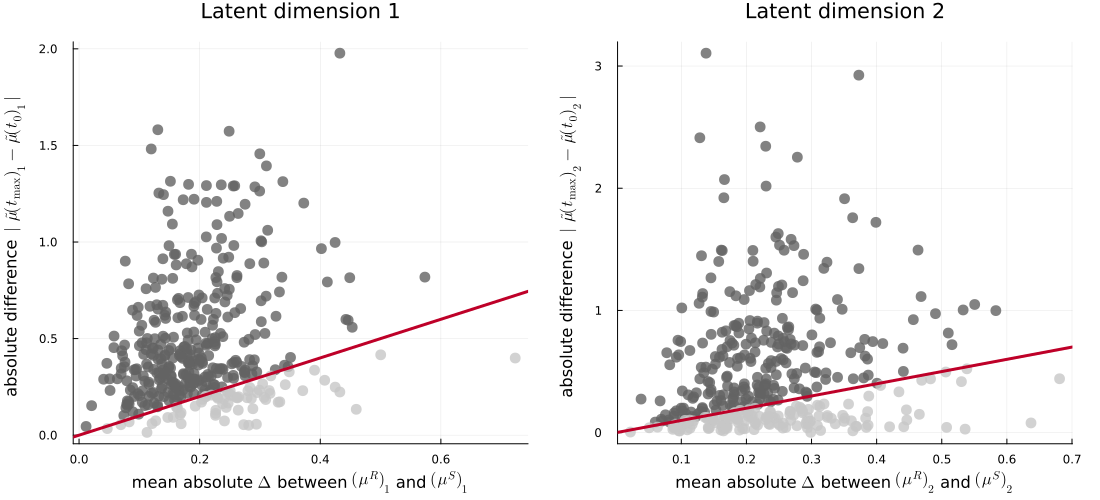

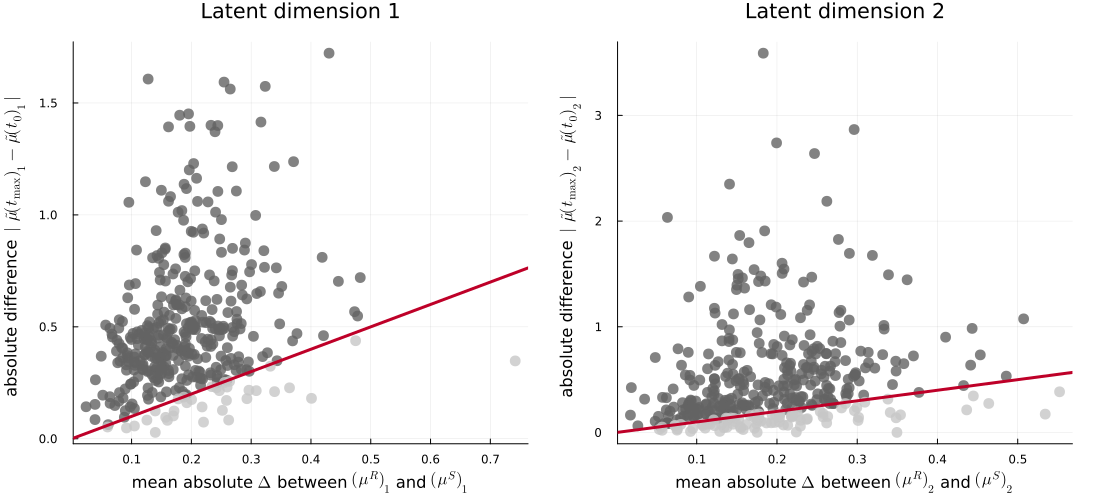

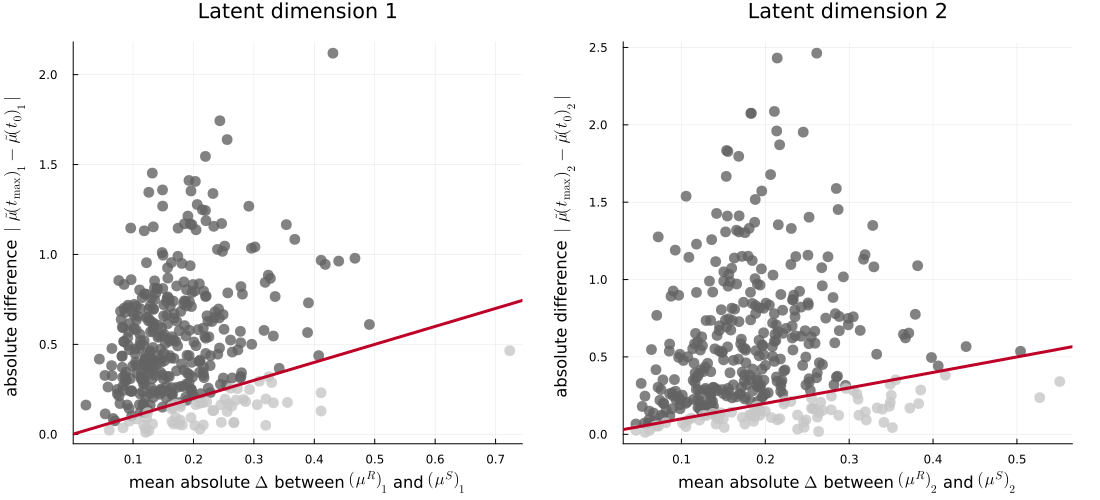

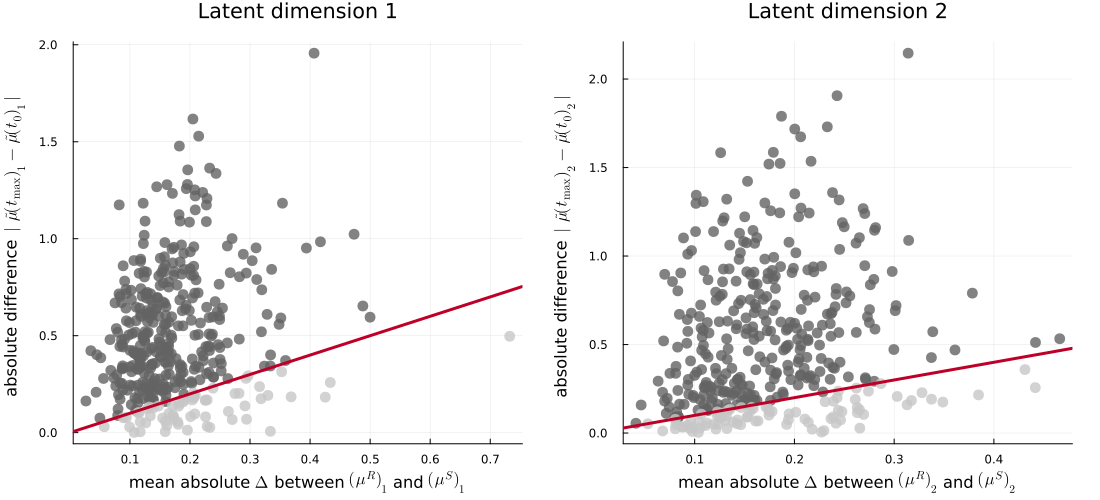

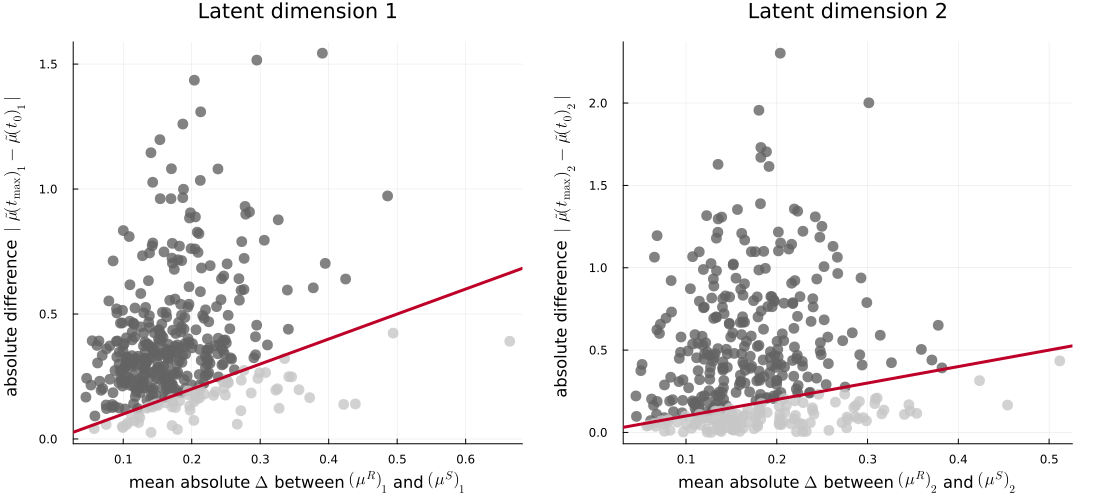

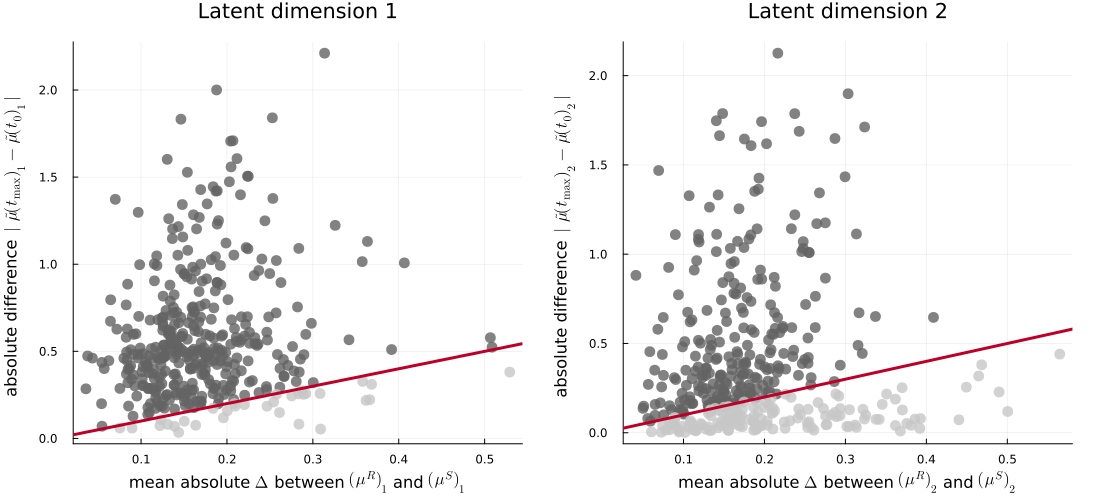

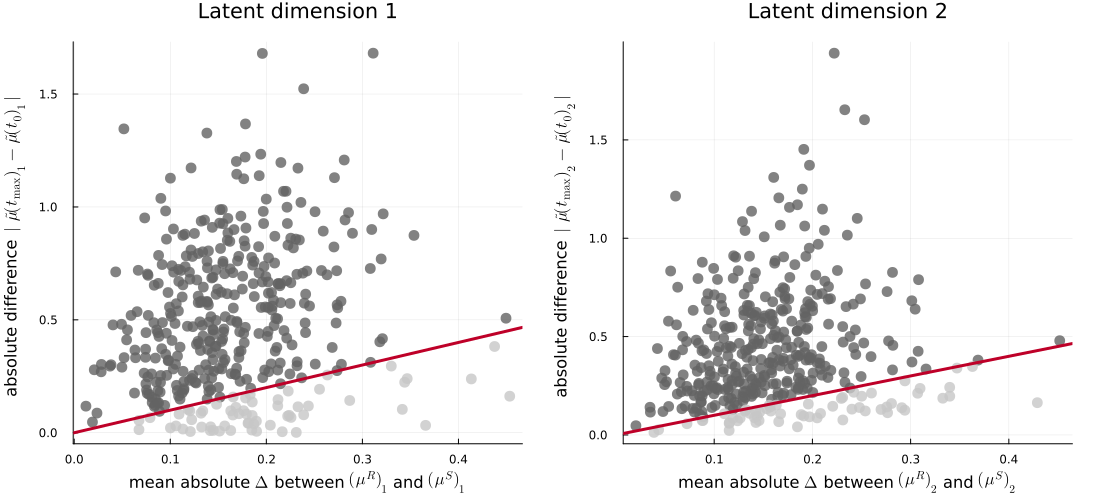

In [57]:
Random.seed!(48)

m1 = odevae(modelargs1);
m2 = odevae(modelargs2);

for epoch_ind in 1:length(epoch_checkpoints)

    # convert epoch number to diff since last checkpoint
    epoch_name = epoch_checkpoints[epoch_ind]
    if length(epoch_checkpoints) == 1
        train_epochs = epoch_checkpoints[1]
    else
        train_epochs = [epoch_checkpoints[1], diff(epoch_checkpoints)...][epoch_ind]
    end

    @info  "Trainig model until epoch $(epoch_name)..."

    # prepare training
    trainingargs_joint=TrainingArgs(warmup=false, epochs=train_epochs, lr=lr)

    # train 
    train_mixed_model!(m1, m2, mixeddata, args_joint, trainingargs_joint, 
        verbose=false, plotting=false
    )

    # plot randomly selected individuals
    Random.seed!(789)
    plot_ids_joint = rand(mixeddata.ids, 12)
    plot_selected_ids(m1, m2, mixeddata, args_joint, plot_ids_joint)
    Random.seed!(789)
    for iter in 1:5
        plot_ids_joint = rand(mixeddata.ids, 12)
        plot_selected_ids(m1, m2, mixeddata, args_joint, plot_ids_joint)
     end  
    
    # look at deltas
    agg_abs_delta_df = make_df_from_deltas(m1, m2, mixeddata)

    # plot
    deltaplot = create_delta_scatterplots(agg_abs_delta_df, 
        fix_limits=false,
        saveplot=true, 
        savepath=resultspath,
        filename="delta_scatterplot_$(epoch_name)epochs.pdf"
    )
    display(deltaplot)

    # collect percentage above diagonal
    above_diagonal_df = collect_stats_about_deltas(agg_abs_delta_df)
    # save to CSV 
    CSV.write(joinpath(resultspath, "above_diagonal_stats_$(epoch_name)epochs.csv"), above_diagonal_df)
end